#MUSHROOM CLASSIFICATION

In [2]:
pip install pySankey

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.optimize import minimize, LinearConstraint, BFGS, Bounds
from scipy import optimize
import matplotlib.colors as pltcolors
from scipy.stats import norm
from scipy.stats import chi2_contingency
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode,iplot
from pySankey.sankey import sankey
from sklearn.metrics import roc_curve

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix

In [5]:
import warnings
warnings.filterwarnings("ignore")

#DATA COLLECTION

In [10]:
df = pd.read_csv("/content/sample_data/Mushroom2-Dataset.csv")

In [11]:
#df = pd.read_csv('Mushroom2-Dataset.csv')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


#DATA EXPLORATION, CLEANING & PREPROCESSING

In [ ]:
mapping_dict = {
    "cap-shape" : {
        "b": "bell","c": "conical","x": "convex","f": "flat","s": "sunken",
        "p": "spherical","o": "others"
    },
    "cap-surface" : {
        "i": "fibrous","g": "grooves","y": "scaly","s": "smooth","h": "shiny",
        "l": "leathery","k": "stilky","t": "sticky","w": "wrinkled","e": "flashy",
        "f": "none"
    },
    "gill-attachment" : {
        "a": "adnate","x": "decurrent","d": "decurrent","e": "free","s": "sinuate",
        "p": "pores","f": "none"
    },
    "gill-spacing": {
        "c": "close","d": "distant","f": "none"
    },
    "stem-root": {
        "b": "bulbous","s": "swollen","c": "club","u": "cup","e": "equal","z": 
        "rhizomorphs","r": "rooted"
    },
    "stem-surface" : {
        "i": "fibrous","g": "grooves","y": "scaly","s": "smooth","h": "shiny","l": 
        "leathery","k": "stilky","t": "sticky","w": "wrinkled","e": "flashy","f": "none"
    },
    "ring-type": {
        "c": "cobwebby","c": "evanescent","r": "flaring","g": "grooved","l": "large","p": 
        "pendant","s": "sheathing","z": "zone","y": "scaly","m": "movable","f": "none",
    },
    "habitat": {
        "g": "grasses","l": "leaves","m": "meadows","p": "paths","h": "heaths","u": "urban",
        "w": "waste","d": "woods",
    },
    "season": {
        "s": "spring","u": "summer","a": "autumn","w": "winter"
    }
}

for col in mapping_dict.keys():
    df = df.replace({col: mapping_dict[col]})

In [ ]:
# color mapping
#brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l
colors = {"b": "buff","n": "brown","g": "gray","r": "green",
          "p": "pink","u": "purple","e": "red","w": "white",
          "y": "yellow","l": "blue","k": "black","f": "none",
          "o": "orange"}
color_cols = ['cap-color', 'gill-color', 'gill-color', 'stem-color', 'veil-color', 'spore-print-color']
for col in color_cols:
    df = df.replace({col: colors})

In [ ]:
df.columns = df.columns.str.replace('-', '_')

In [ ]:
# PERCENTAGE OF NULL VALUES IN EACH COLUMNS
na_count=round((df.isnull().sum()/len(df))*100, 2) 
na_count

class                    0.00
cap_diameter             0.00
cap_shape                0.00
cap_surface             23.12
cap_color                0.00
does_bruise_or_bleed     0.00
gill_attachment         16.18
gill_spacing            41.04
gill_color               0.00
stem_height              0.00
stem_width               0.00
stem_root               84.39
stem_surface            62.43
stem_color               0.00
veil_type               94.80
veil_color              87.86
has_ring                 0.00
ring_type                4.05
spore_print_color       89.60
habitat                  0.00
season                   0.00
dtype: float64

In [ ]:
#Drop the variables which have more than 60% missing values
x=pd.DataFrame(data=na_count,columns=["Missing Values"]).reset_index()
x.rename(columns={"index":"Column"}, inplace=True)
y=x[x["Missing Values"]>60]
df1=df.drop(y["Column"],axis=1)

In [ ]:
##imputing "Unknown" class to all the remaining null values
df2 = df1.fillna("Unknown")
df2.head()

,class,cap_diameter,cap_shape,cap_surface,cap_color,does_bruise_or_bleed,gill_attachment,gill_spacing,gill_color,stem_height,stem_width,stem_color,has_ring,ring_type,habitat,season
0,p,15.26,convex,grooves,orange,f,free,Unknown,white,16.95,17.09,white,t,grooved,woods,winter
1,p,16.60,convex,grooves,orange,f,free,Unknown,white,17.99,18.19,white,t,grooved,woods,summer
2,p,14.07,convex,grooves,orange,f,free,Unknown,white,17.80,17.74,white,t,grooved,woods,winter
3,p,14.17,flat,shiny,red,f,free,Unknown,white,15.77,15.98,white,t,pendant,woods,winter
4,p,14.64,convex,shiny,orange,f,free,Unknown,white,16.53,17.20,white,t,pendant,woods,winter


In [ ]:
df2.describe()

,cap_diameter,stem_height,stem_width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


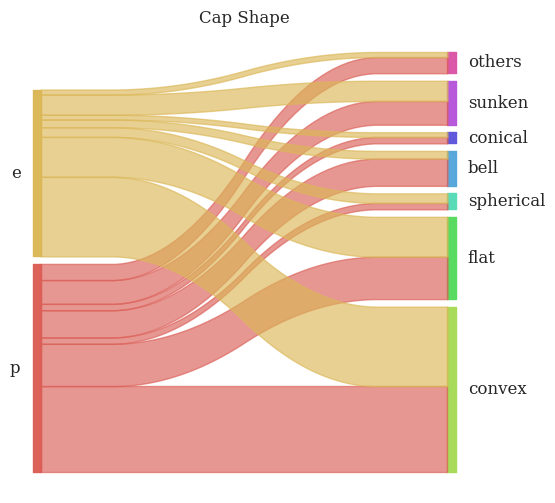

In [ ]:
sankey(
    left=df2['class'], right=df2['cap_shape'],
    fontsize=12,)
plt.gcf().set_size_inches((6,6))
plt.title('Cap Shape')
plt.show()

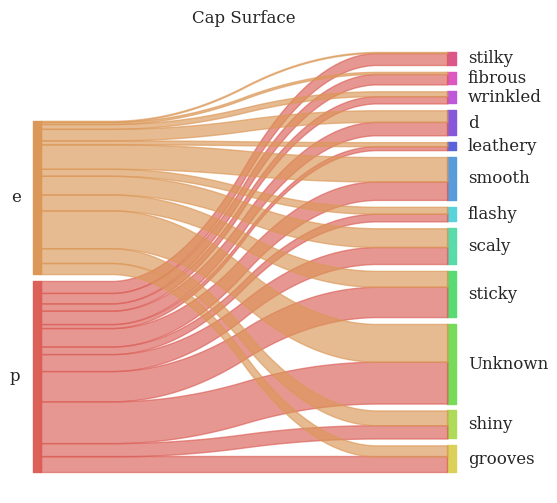

In [ ]:
sankey(
    left=df2['class'], right=df2['cap_surface'],
    fontsize=12,)
plt.gcf().set_size_inches((6,6))
plt.title('Cap Surface')
plt.show()

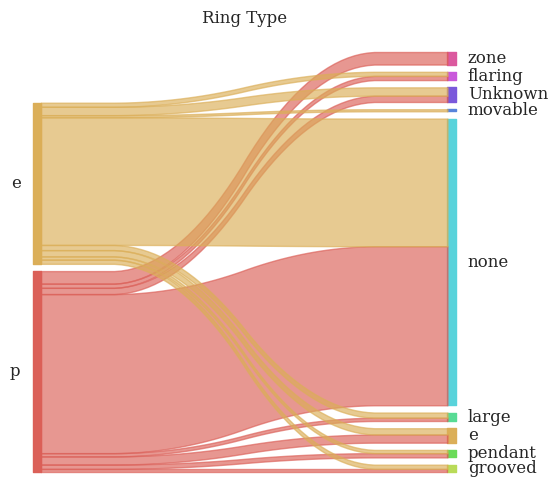

In [ ]:
sankey(
    left=df2['class'], right=df2['ring_type'],
    fontsize=12,)
plt.gcf().set_size_inches((6,6))
plt.title('Ring Type')
plt.show()

**CORRELATION PLOT**

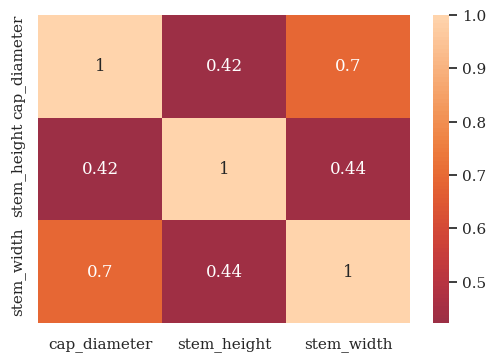

In [ ]:
# Finding Correlation between between numerical variables through Heatmap
corr = df2.corr()
sns.heatmap(corr, annot=True, center=0)
plt.show()
#fig, ax = plt.subplots()
#fig.set_size_inches(10, 8)
#sns.heatmap(corr, annot = True, center=0, ax = ax)

**Chi-Square Test- Before One Hot Encoding**

In [ ]:
data= df2.drop(['cap_diameter','stem_height','stem_width'], axis=1)

In [ ]:
# get the list of column names in the dataframe
columns = data.columns.tolist()

# loop over class vs all other pairs of columns
for j in range(len(columns)):
        # create a contingency table of the two variables
        contingency_table = pd.crosstab(data["class"], data[columns[j]])
        
        # perform the chi-square test and print the p-value
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        #if p>0.05:
        print(f"Chi-square test between class and{columns[j]}: p-value = {p}")
        #else:
           # print(f"Keep the variables {columns[i]} and {columns[j]}")

Chi-square test between class andclass: p-value = 0.0
Chi-square test between class andcap_shape: p-value = 0.0
Chi-square test between class andcap_surface: p-value = 0.0
Chi-square test between class andcap_color: p-value = 0.0
Chi-square test between class anddoes_bruise_or_bleed: p-value = 9.381208881872168e-07
Chi-square test between class andgill_attachment: p-value = 0.0
Chi-square test between class andgill_spacing: p-value = 4.645795288240711e-173
Chi-square test between class andgill_color: p-value = 0.0
Chi-square test between class andstem_color: p-value = 0.0
Chi-square test between class andhas_ring: p-value = 7.427498993566696e-46
Chi-square test between class andring_type: p-value = 0.0
Chi-square test between class andhabitat: p-value = 0.0
Chi-square test between class andseason: p-value = 4.0178666316236727e-181


For Nomminal variables, p-value is less than level of significance of 0.05, so we reject the null hypothesis and conclude that there is evidence of a relationship between the two variables. In this case, we want to keep the variables in your analysis.
However in case of Numerical Variables, we can see high correlation between stem height and cap diameter, we plan to drop cap diameter

In [ ]:
df3= df2.drop("cap_diameter", axis=1) # Dropping Cap Diameter which has multicollinearity with stem width

In [ ]:
df3.head()

,class,cap_shape,cap_surface,cap_color,does_bruise_or_bleed,gill_attachment,gill_spacing,gill_color,stem_height,stem_width,stem_color,has_ring,ring_type,habitat,season
0,p,convex,grooves,orange,f,free,Unknown,white,16.95,17.09,white,t,grooved,woods,winter
1,p,convex,grooves,orange,f,free,Unknown,white,17.99,18.19,white,t,grooved,woods,summer
2,p,convex,grooves,orange,f,free,Unknown,white,17.80,17.74,white,t,grooved,woods,winter
3,p,flat,shiny,red,f,free,Unknown,white,15.77,15.98,white,t,pendant,woods,winter
4,p,convex,shiny,orange,f,free,Unknown,white,16.53,17.20,white,t,pendant,woods,winter


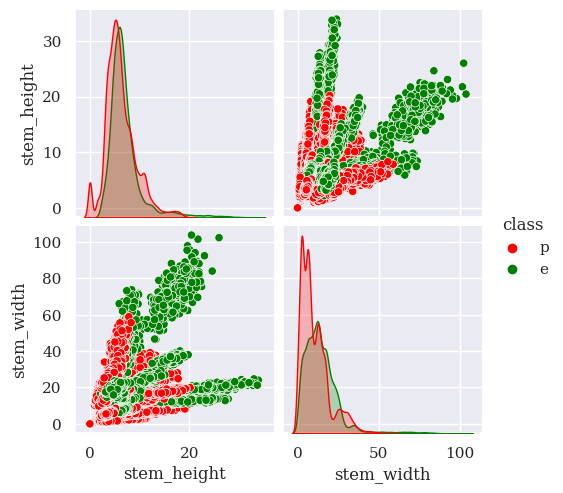

In [ ]:
import seaborn as sns
sns.pairplot(df3, hue='class', palette={'p': 'red', 'e': 'green'})

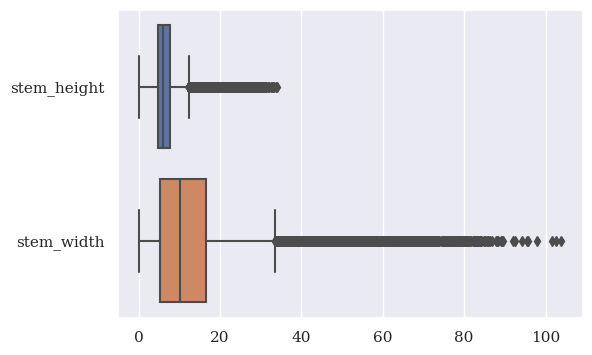

In [ ]:
sns.boxplot(data=df3[["stem_height", "stem_width"]], orient="h")
sns.set(rc={"figure.figsize":(8, 8)}) #width=3, #height=4
plt.show()

In [ ]:
#Target Class: To check if dataset is imbalanced
target_class = df3["class"].value_counts()
target_class

p    33888
e    27181
Name: class, dtype: int64

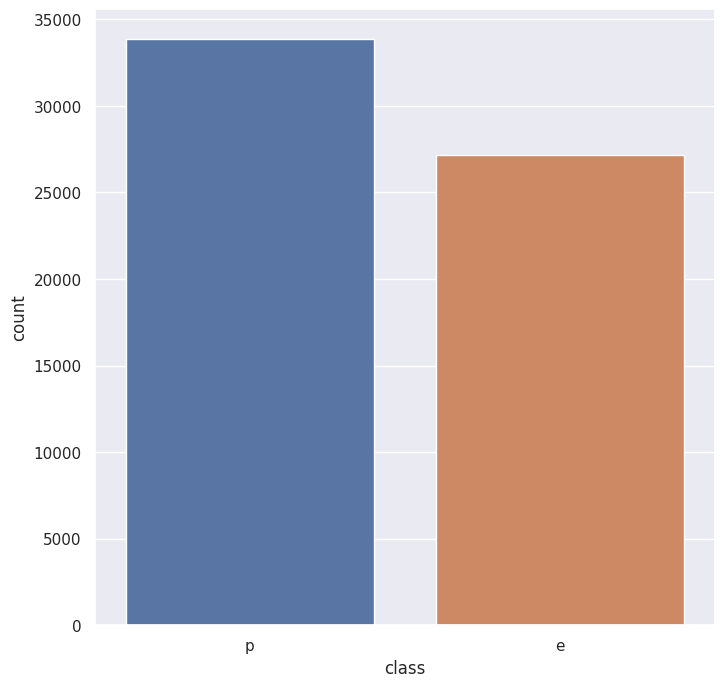

In [ ]:
sns.countplot(data=df3, x='class')
sns.set(rc={"figure.figsize":(6, 4)})
plt.show()

In [ ]:
#One-Hot Encoding
cat_var= ['cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed',
            'gill_attachment', 'gill_spacing', 'gill_color', 'stem_color',
            'has_ring', 'ring_type', 'habitat', 'season']

df4 = pd.get_dummies(df3, columns=cat_var, drop_first=True)

In [ ]:
df4.head()

,class,stem_height,stem_width,cap_shape_conical,cap_shape_convex,cap_shape_flat,cap_shape_others,cap_shape_spherical,cap_shape_sunken,cap_surface_d,...,habitat_heaths,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,season_spring,season_summer,season_winter
0,p,16.95,17.09,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,p,17.99,18.19,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,p,17.80,17.74,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,p,15.77,15.98,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,p,16.53,17.20,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


**Chi- Sqaure Test after One Hot encoding**

In [ ]:
data1= df4.drop(['stem_height','stem_width'], axis=1)

In [ ]:
# get the list of column names in the dataframe
cols_to_drop = []
columns = data1.columns.tolist()

# loop over class vs all other pairs of columns
for j in range(len(columns)):
        # create a contingency table of the two variables
        contingency_table = pd.crosstab(data["class"], data1[columns[j]])
        
        # perform the chi-square test and print the p-value
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        if p>0.05:
          print(f"Chi-square test between class and{columns[j]}: p-value = {p}")
          cols_to_drop.append(columns[j])
        else:
          print(f"Keep the variables class and {columns[j]}")

data1 = data1.drop(cols_to_drop, axis=1)

Keep the variables class and class
Chi-square test between class andcap_shape_conical: p-value = 0.10998746709234247
Keep the variables class and cap_shape_convex
Keep the variables class and cap_shape_flat
Keep the variables class and cap_shape_others
Keep the variables class and cap_shape_spherical
Keep the variables class and cap_shape_sunken
Keep the variables class and cap_surface_d
Keep the variables class and cap_surface_fibrous
Keep the variables class and cap_surface_flashy
Keep the variables class and cap_surface_grooves
Keep the variables class and cap_surface_leathery
Keep the variables class and cap_surface_scaly
Keep the variables class and cap_surface_shiny
Keep the variables class and cap_surface_smooth
Keep the variables class and cap_surface_sticky
Keep the variables class and cap_surface_stilky
Keep the variables class and cap_surface_wrinkled
Keep the variables class and cap_color_blue
Keep the variables class and cap_color_brown
Keep the variables class and cap_col

In [ ]:
data1.head()

,class,cap_shape_convex,cap_shape_flat,cap_shape_others,cap_shape_spherical,cap_shape_sunken,cap_surface_d,cap_surface_fibrous,cap_surface_flashy,cap_surface_grooves,...,habitat_heaths,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,season_spring,season_summer,season_winter
0,p,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,p,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
2,p,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,p,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,p,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
df_num = df4. iloc[:, [1,2]]
df_num.head()

,stem_height,stem_width
0,16.95,17.09
1,17.99,18.19
2,17.80,17.74
3,15.77,15.98
4,16.53,17.20


In [ ]:
df4 = pd.concat([df_num, data1], axis=1)
df4.head()

,stem_height,stem_width,class,cap_shape_convex,cap_shape_flat,cap_shape_others,cap_shape_spherical,cap_shape_sunken,cap_surface_d,cap_surface_fibrous,...,habitat_heaths,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,season_spring,season_summer,season_winter
0,16.95,17.09,p,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,17.99,18.19,p,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,17.80,17.74,p,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,15.77,15.98,p,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,16.53,17.20,p,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
# create X and y matrices
X = df4.drop('class', axis=1).values # drop the 'class' column and convert to numpy array
y = np.where(df4['class'] == 'p', 1, 0) # create a binary target variable (1 for poisonous, 0 for edible)

print(X.shape)
print(y.shape)

(61069, 75)
(61069,)


#DIMENSIONALITY REDUCTION

In [ ]:
X=pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,16.95,17.09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,17.99,18.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,17.80,17.74,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,15.77,15.98,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,16.53,17.20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
num_vars = X.select_dtypes(include=['float64', 'int64']).columns
bin_vars = X.select_dtypes(include=['object', 'bool']).columns

In [ ]:
X[num_vars] = (X[num_vars] - X[num_vars].mean()) / X[num_vars].std()

In [ ]:
cov_matrix = np.cov(X[num_vars].T)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [ ]:
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:,sorted_indices]

In [ ]:
total_variance = sum(eigenvalues)
variance_explained = [(i / total_variance) for i in sorted(eigenvalues, reverse=True)]
cumulative_variance_explained = np.cumsum(variance_explained)

print(cumulative_variance_explained)

num_PCs = np.argmax(cumulative_variance_explained >= 0.95) + 1

[0.05868493 0.09977782 0.13819981 0.17229572 0.2022559  0.2312619
 0.25786291 0.28356879 0.30855784 0.33247303 0.3548097  0.37679257
 0.39758866 0.41818456 0.43774297 0.45714932 0.47567186 0.49319202
 0.51022026 0.52678427 0.54314009 0.55931298 0.57484158 0.59003236
 0.60497903 0.61974409 0.63409303 0.64820116 0.66186661 0.67512458
 0.68828451 0.70125348 0.7139603  0.72646397 0.73859122 0.75047119
 0.76227058 0.77385867 0.7849883  0.79587117 0.80649409 0.81682361
 0.82698332 0.83678369 0.84637427 0.85589389 0.86526132 0.87431763
 0.88305752 0.89158041 0.89990216 0.90802633 0.91580623 0.9233355
 0.93047436 0.93751424 0.94425703 0.9508648  0.95704295 0.96305786
 0.96852799 0.97359692 0.97830058 0.98246479 0.98613891 0.98958995
 0.99248308 0.99508404 0.99727579 0.99868918 0.99941985 0.99973177
 1.         1.         1.        ]


In [ ]:
num_PCs

58

In [ ]:
projection_matrix = sorted_eigenvectors[:, :num_PCs]

In [ ]:
new_data = X[num_vars].dot(projection_matrix)

In [ ]:
new_data

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,1.880128,3.872515,0.861586,-0.460902,2.543302,1.636599,0.049534,-0.513647,1.288648,-1.505576,...,-0.425441,-0.093879,1.720448,-1.029998,0.234246,1.182591,-0.065386,-0.574073,0.596253,0.828477
1,2.028491,4.016647,1.156985,-0.785963,2.398258,1.487131,-0.242022,-1.191386,1.947025,-0.886289,...,-0.278494,-0.109750,1.102915,-0.556563,0.291406,1.006060,0.538783,-0.330733,0.777408,1.338737
2,1.921626,3.940544,0.909952,-0.542564,2.525973,1.664264,0.068300,-0.459864,1.308533,-1.481969,...,-0.452431,-0.082375,1.720105,-1.006915,0.247883,1.218987,-0.086934,-0.552882,0.601537,0.861994
3,1.444819,2.993634,-0.003246,-0.958191,1.327689,1.739400,-0.154055,0.702090,-0.700771,-0.954085,...,-1.027586,0.290839,0.291875,0.155820,-0.774070,0.953010,-2.259886,0.703974,-0.702402,0.381878
4,1.617302,2.834585,1.024397,-0.559374,1.893075,0.574406,0.832453,0.152806,0.313790,-1.619886,...,-0.212255,0.702136,1.341342,-0.516756,-1.512501,1.211707,-2.349976,0.960896,1.054372,1.185957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,-6.589842,-0.208678,0.086923,-0.621070,1.943997,-1.264654,0.570644,0.168148,1.156544,0.632384,...,0.603407,0.929589,-0.917245,0.014926,-0.176910,0.379530,-0.415162,-0.458573,-0.116062,0.575411
61065,-6.415661,0.188392,0.125790,0.040264,2.048353,-0.765010,1.044907,0.877501,0.878548,0.407965,...,0.283428,1.145499,-0.341310,0.123795,-0.127407,-0.248813,-0.316600,-0.410343,0.512278,0.348073
61066,-6.553696,-0.170436,0.114547,-0.683331,1.873649,-1.302910,0.461969,-0.139622,1.442743,0.713607,...,0.672915,0.832918,-0.267737,0.148207,0.053135,0.860523,-0.351512,-0.182069,-0.243294,0.260145
61067,-6.356447,0.258790,0.172051,-0.045965,1.970905,-0.794541,0.943492,0.591085,1.175453,0.500113,...,0.339436,1.054437,0.306835,0.266055,0.105945,0.255854,-0.269280,-0.122517,0.385269,0.050447


#MODEL IMPLEMENTATION AND PERFORMANCE EVALUATION

#**LOGISTIC REGRESSION**

In [ ]:
X= new_data

In [ ]:
class LogisticRegression:
    def __init__(self, X, y, learningRate, tolerance, maxIteration, 
                 gd,stochastic_gd, regularization, ridge_lambda, lasso):
        self.tolerance = tolerance
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.X= X
        self.y= y
        self.w = None
        self.gd = gd
        self.stochastic_gd = stochastic_gd
        self.regularization= regularization
        self.ridge_lambda = ridge_lambda
        self.lasso=lasso
        
        
    def splitData(self):
        X_Train, X_Test, y_Train, y_Test = train_test_split(self.X,self.y,test_size=0.3,random_state=42)
        return X_Train, X_Test, y_Train, y_Test

    def sigmoid(self, z):
        sig = 1/(1+np.exp(-z))
        return sig

    def costFunction(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        # approach1
        cost = (y*np.log(sig)+(1-y)*np.log(1-sig)).sum()
        cost = -cost/X.shape[0]
        return cost

    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        gradient = (sig-y).dot(X)
        return gradient
    
    def gradientDescent(self, X, y):
        errors = []
        last_error = float('inf')
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_error = self.costFunction(X, y)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)

            if np.abs(diff) < self.tolerance:
                print('model stopped learning')
                break
    
    ## COST FUNCTION WITH REGULARIZATION - L2 NORM
    def costFunctionWithRegularization(self,X,y):
        return self.costFunction(X, y) + (self.ridge_lambda*np.sum(self.w**2))/2

    ## COST FUNCTION DERIVATIVE WITH REGULARIZATION- L2 NORM
    def l2_gradient(self,X,y):
        gradient_with_l2 = self.gradient(X,y)+ self.ridge_lambda*self.w
        return gradient_with_l2

    ## GRADIENT DESCENT WITH REGULARIZATION- L2 NORM
    def gradientWithRegularization(self,X_Train,y_Train):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - (self.learningRate * self.l2_gradient(X_Train, y_Train))
            current_error = self.costFunctionWithRegularization(X_Train,y_Train)
            error_diff= np.abs(error_prev - current_error)
            error_prev = current_error
            errors.append(current_error)
            if error_diff < self.tolerance:
                print('Model stopped running')
                break
    
    ## COST FUNCTION DERIVATIVE WITH REGULARIZATION - L1 NORM
    def costFunctionWithRegularizationLasso(self,X,y):
        return self.costFunction(X,y) + (self.ridge_lambda*np.sum(abs(self.w)))
    
    ## COST FUNCTION DERIVATIVE WITH REGULARIZATION- L1 NORM
    def l1_gradient(self,X,y):
        gradient_with_l1 = self.gradient(X,y)+ np.sign(self.w)
        return gradient_with_l1
        #y_hat = self.predict(X)
        #return (y_hat - y).dot(X) + geek.sign(self.w)
    
    ## GRADIENT DESCENT WITH REGULARIZATION - L1 NORM
    def gradientWithRegularizationLasso(self,X_Train,y_Train):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
            #gradient = self.costDerivativeWithRegularizationLasso(X_Train,y_Train)
            self.w = self.w - (self.learningRate * self.l1_gradient(X_Train, y_Train))
            current_error = self.costFunctionWithRegularizationLasso(X_Train,y_Train)
            error_diff= error_prev - current_error
            error_prev = current_error
            errors.append(current_error)
            if np.abs(error_diff) < self.tolerance:
                print('Model stopped running')
                break
    
    #STOCHASTIC GRADIENT DESCENT
    def stochasticGradientDescent(self, X_Train, y_Train):
        
        errors = []
        last_error = float('inf')
        for i in tqdm(range(self.maxIteration)):
            X_Gradient_Sample, _, y_Gradient_Sample ,__  = train_test_split(X_Train,y_Train,test_size=0.80,shuffle=True)
            self.w = self.w - self.learningRate * self.gradient(X_Gradient_Sample,y_Gradient_Sample)
            current_error = self.costFunction(X_Gradient_Sample,y_Gradient_Sample)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)

            if np.abs(diff) < self.tolerance:
                print('model stopped learning')
                break
        

    ## STOCHASTIC GRADIENT DESCENT WITH REGULARIZATION-l1 NORM
    def stochasticGradientWithRegularization(self,X_Train,y_Train):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
            X_Gradient_Sample, _, y_Gradient_Sample ,__  = train_test_split(X_Train,y_Train,test_size=0.80,shuffle=True)
            #gradient = self.costDerivativeWithRegularization(X_Gradient_Sample,y_Gradient_Sample)
            self.w = self.w - (self.learningRate * self.l2_gradient(X_Gradient_Sample,y_Gradient_Sample))
            current_error = self.costFunctionWithRegularization(X_Gradient_Sample,y_Gradient_Sample)
            error_diff= error_prev - current_error
            error_prev = current_error
            errors.append(current_error)
            if np.abs(error_diff) < self.tolerance:
                print('Model stopped running')
                break
                
    
    ## STOCHASTIC GRADIENT DESCENT WITH REGULARIZATION- L1 NORM
    def stochasticGradientWithRegularizationLasso(self,X_Train,y_Train):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
            X_Gradient_Sample, _, y_Gradient_Sample ,__  = train_test_split(X_Train,y_Train,test_size=0.80,shuffle=True)
            #gradient = self.costDerivativeWithRegularizationLasso(X_Gradient_Sample,y_Gradient_Sample)
            self.w = self.w - (self.learningRate * self.l1_gradient(X_Gradient_Sample,y_Gradient_Sample))
            current_error = self.costFunctionWithRegularizationLasso(X_Gradient_Sample,y_Gradient_Sample)
            error_diff= error_prev - current_error
            error_prev = current_error
            errors.append(current_error)
            if np.abs(error_diff) < self.tolerance:
                print('Model stopped running')
                break
    

    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)   
    
    def predict_proba(self, X):
        # Get the predicted probabilities from the model
        y_pred = self.predict(X)
    
        # Compute the class probabilities
        proba = np.zeros((X.shape[0], 2))
        proba[:, 0] = 1 - y_pred
        proba[:, 1] = y_pred
    
        return proba
    
    def evaluate(self, y, y_hat):
        y = (y==1)
        y_hat = (y_hat == 1)        
        correct_predictions = (y == y_hat).sum()
        total_predictions = len(y)
        accuracy = correct_predictions / total_predictions
        recall = (y & y_hat).sum()/y.sum()
        precision = (y & y_hat).sum()/y_hat.sum()
        f_score = 2*(precision*recall)/(precision+recall)
        return accuracy, f_score, recall, precision

    
    def scores(self,X,y):
        X_train,X_test,y_train,y_test = self.splitData()
        y_train_hat = self.predict(X_train)
        accuracy, f_score, recall, precision = self.evaluate(y_train, y_train_hat)
        print('Training F1 score {}'.format(f_score))
        print('Training recall score {}'.format(recall))
        print('Training precision score {}'.format(precision))
        print('Training accuracy score {}'.format(accuracy))
        print('-----------------------------------------------')
        y_test_hat= self.predict(X_test)
        accuracy,f_score, recall, precision = self.evaluate(y_test, y_test_hat)
        print('Testing F1 score {}'.format(f_score))
        print('Testing recall score {}'.format(recall))
        print('Testing precision score {}'.format(precision))
        print('Testing accuracy score {}'.format(accuracy))

        y_pred_proba = self.predict_proba(X_test)[:, 1] # Call predict_proba method on trained model object
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    
    
    def fit(self,X_Train,y_Train):
        X_train,X_test,y_train,y_test = self.splitData()
        print('Solving using Gradient Descent')
        
        if self.gd and not self.regularization and not self.lasso:
            print('Solved using gradient descent without regularization')
            self.w = np.ones(X_train.shape[1])
            self.gradientDescent(X_train,y_train)
            
        elif self.gd and self.regularization and not self.lasso:
            print('Solved using gradient descent with regularization- RIDGE REGRESSION')
            self.w = np.ones(X_train.shape[1])
            self.gradientWithRegularization(X_train,y_train)
        
        elif self.gd and not self.regularization and self.lasso:
            print('Solved using gradient descent with regularization- LASSO REGRESSION')
            self.w = np.ones(X_train.shape[1])
            self.gradientWithRegularizationLasso(X_train,y_train)
        
        elif self.stochastic_gd and not self.regularization and not self.lasso:
            print('Solved using stochastic gradient descent with out regularization')
            self.w = np.ones(X_train.shape[1])
            self.stochasticGradientDescent(X_train,y_train)
        
        elif self.stochastic_gd and self.regularization and not self.lasso:
            print('Solved using stochastic gradient descent with regularization- RIDGE REGRESSION')
            self.w = np.ones(X_train.shape[1])
            self.stochasticGradientWithRegularization(X_train,y_train)
        
        elif self.stochastic_gd and not self.regularization and self.lasso:
            print('Solved using stochastic gradient descent with regularization- LASSO REGRESSION')
            self.w = np.ones(X_train.shape[1])
            self.stochasticGradientWithRegularizationLasso(X_train,y_train)

        

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=True,stochastic_gd= False, regularization=False,lasso=False, ridge_lambda=None)

Solving using Gradient Descent
Solved using gradient descent without regularization


100%|██████████| 5000/5000 [00:49<00:00, 100.98it/s]


Training F1 score 0.7372498671861165
Training recall score 0.7034002111932418
Training precision score 0.7745221152504534
Training accuracy score 0.7223261906989801
-----------------------------------------------
Testing F1 score 0.7375581811672037
Testing recall score 0.7059629883481837
Testing precision score 0.7721139430284858
Testing accuracy score 0.7199388679657224


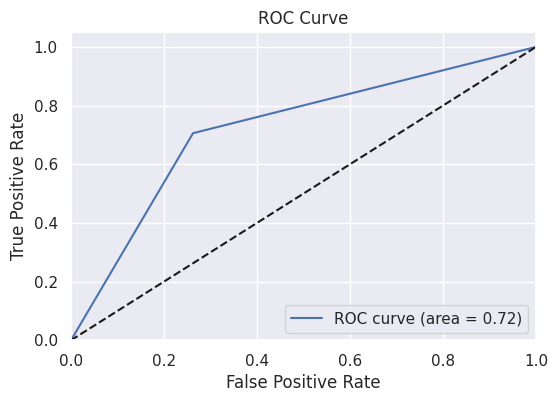

In [ ]:
lr.fit(X_train, y_train)
lr.scores(X_train,y_train)

In [ ]:
lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=True, stochastic_gd= False, regularization=True,lasso=False, ridge_lambda=0.1)

Solving using Gradient Descent
Solved using gradient descent with regularization- RIDGE REGRESSION


100%|██████████| 5000/5000 [01:52<00:00, 44.61it/s]


Training F1 score 0.7364420341394026
Training recall score 0.703123673711909
Training precision score 0.7730751283247783
Training accuracy score 0.7226069055862263
-----------------------------------------------
Testing F1 score 0.737981014596305
Testing recall score 0.7001743172574085
Testing precision score 0.7801035822183858
Testing accuracy score 0.719775121445336


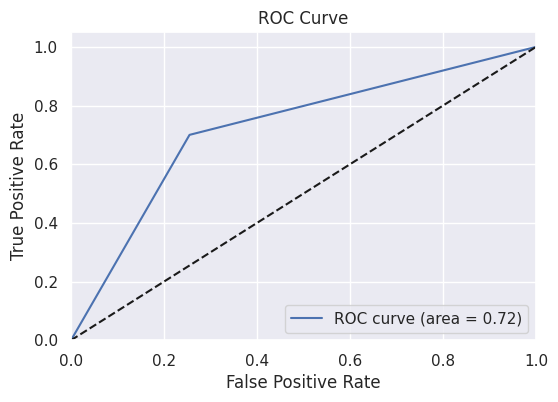

In [ ]:
lr.fit(X_train, y_train)
lr.scores(X_train,y_train)

In [ ]:
lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=True,stochastic_gd=False, regularization=False,lasso=True, ridge_lambda=0.1)

Solving using Gradient Descent
Solved using gradient descent with regularization- LASSO REGRESSION


100%|██████████| 5000/5000 [01:52<00:00, 44.42it/s]


Training F1 score 0.7362827923521565
Training recall score 0.7027841439606145
Training precision score 0.7731347464749276
Training accuracy score 0.7225133339571442
-----------------------------------------------
Testing F1 score 0.7378254211332314
Testing recall score 0.699883788495061
Testing precision score 0.7801165803108808
Testing accuracy score 0.7196659570984116


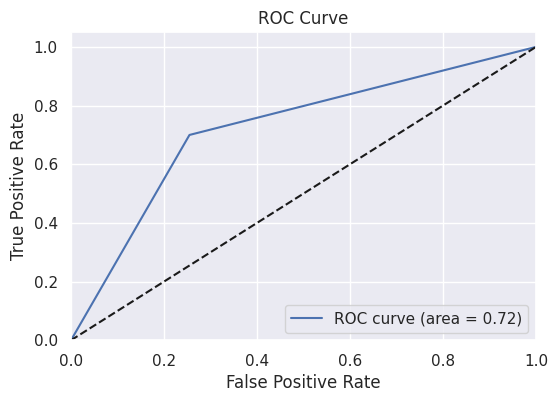

In [ ]:
lr.fit(X_train, y_train)
lr.scores(X_train,y_train)

In [ ]:
lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=False,stochastic_gd= True, regularization=False,lasso=False, ridge_lambda=None)

Solving using Gradient Descent
Solved using stochastic gradient descent with out regularization


  1%|          | 46/5000 [00:00<01:32, 53.32it/s]


model stopped learning
Training F1 score 0.7446085569655364
Training recall score 0.6836007130124777
Training precision score 0.8175727120450739
Training accuracy score 0.7415317675680734
-----------------------------------------------
Testing F1 score 0.7456093666844066
Testing recall score 0.678384660081348
Testing precision score 0.8276228733459358
Testing accuracy score 0.739097210850936


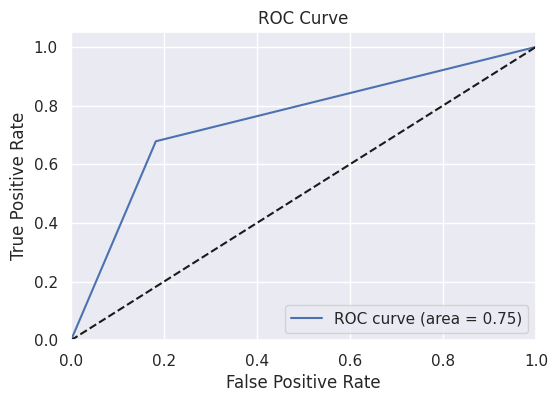

In [ ]:
lr.fit(X_train, y_train)
lr.scores(X_train,y_train)

In [ ]:
lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=False,stochastic_gd= True, regularization=True,lasso=False, ridge_lambda=0.1)

Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- RIDGE REGRESSION


  5%|▍         | 238/5000 [00:06<02:12, 35.91it/s]


Model stopped running
Training F1 score 0.7550382289170374
Training recall score 0.702020202020202
Training precision score 0.8167185108379006
Training accuracy score 0.7489239262655563
-----------------------------------------------
Testing F1 score 0.7549251379038613
Testing recall score 0.6958163858221964
Testing precision score 0.8250086117809163
Testing accuracy score 0.745374160799083


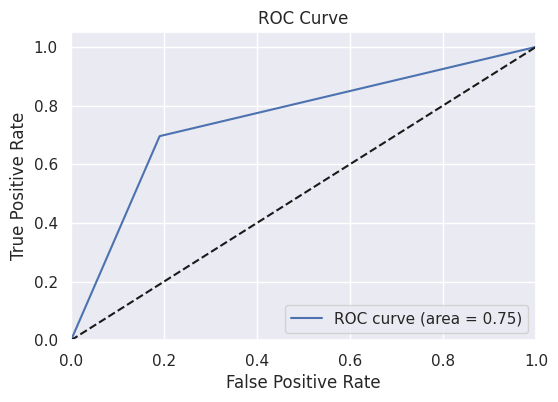

In [ ]:
lr.fit(X_train, y_train)
lr.scores(X_train,y_train)

In [ ]:
lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=False,stochastic_gd= True, regularization=False,lasso=True, ridge_lambda=0.1)

Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  3%|▎         | 156/5000 [00:04<02:30, 32.15it/s]


Model stopped running
Training F1 score 0.7558160668847692
Training recall score 0.70259767687434
Training precision score 0.8177572390737918
Training accuracy score 0.7485730326564985
-----------------------------------------------
Testing F1 score 0.7551214361140443
Testing recall score 0.7001860374033095
Testing precision score 0.8194110232611436
Testing accuracy score 0.746847879482561


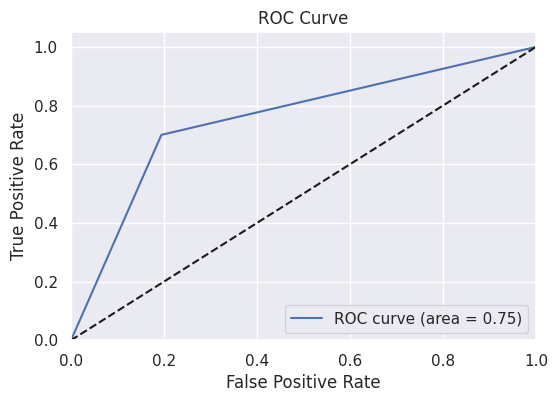

In [ ]:
lr.fit(X_train, y_train)
lr.scores(X_train,y_train)

**Undersampling and checking the performance**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import TomekLinks


# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# determine class distribution of training set
print("Before Undersampling:")
y_train_series = pd.Series(y_train)
print(y_train_series.value_counts())


# apply Random Undersampler to the training set
u1 = TomekLinks()
X_train_rus, y_train_rus = u1.fit_resample(X_train, y_train)

u2 = RandomUnderSampler()
X_train_res, y_train_res = u2.fit_resample(X_train, y_train)

u3 = NearMiss()
X_train_nm, y_train_nm = u3.fit_resample(X_train, y_train)

# determine class distribution of resampled training set
print("After Undersampling-Tomeklinks:")
y_train_rus_series = pd.Series(y_train_rus)
print(y_train_rus_series.value_counts())
#print(y_train_res.value_counts())

# train a classification model using the resampled training set
#lr.fit(X_train_rus, y_train_rus)

# evaluate the model's performance on the test set
y_pred1= lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))

print("After Undersampling:- RandomUndersampler")
y_train_res_series = pd.Series(y_train_res)
print(y_train_res_series.value_counts())
#print(y_train_res.value_counts())

# train a classification model using the resampled training set
#lr.fit(X_train_res, y_train_res)

# evaluate the model's performance on the test set
y_pred2 = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))


print("After Undersampling-Near Miss:")
y_train_nm_series = pd.Series(y_train_nm)
print(y_train_nm_series.value_counts())
#print(y_train_res.value_counts())

# train a classification model using the resampled training set
#lr.fit(X_train_nm, y_train_nm)

# evaluate the model's performance on the test set
y_pred3 = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))

Before Undersampling:
1    27048
0    21807
dtype: int64
After Undersampling-Tomeklinks:
1    27048
0    21807
dtype: int64
Accuracy: 0.72089405600131
After Undersampling:- RandomUndersampler
0    21807
1    21807
dtype: int64
Accuracy: 0.72089405600131
After Undersampling-Near Miss:
0    21807
1    21807
dtype: int64
Accuracy: 0.72089405600131


In [ ]:
lr_underSample = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=False,stochastic_gd= True, regularization=True,lasso=False, ridge_lambda=0.1)

Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- RIDGE REGRESSION


  6%|▌         | 312/5000 [00:10<02:38, 29.61it/s]


Model stopped running
Training F1 score 0.7592084818572342
Training recall score 0.7050759697818522
Training precision score 0.8223443223443223
Training accuracy score 0.7534855431833068
-----------------------------------------------
Testing F1 score 0.7589867563590499
Testing recall score 0.6993027309703661
Testing precision score 0.8298092392553436
Testing accuracy score 0.7496861525025926


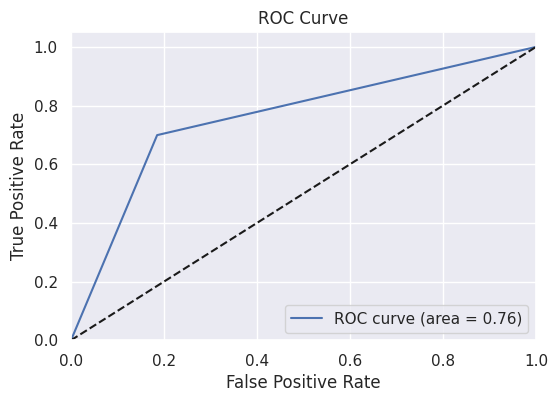

In [ ]:
lr_underSample.fit(X_train_res, y_train_res)
lr.scores(X_train_res, y_train_res)

**BIAS VARIANCE TRADE-OFF**

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  3%|▎         | 160/5000 [00:18<09:16,  8.70it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  2%|▏         | 120/5000 [00:13<09:06,  8.93it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  1%|▏         | 69/5000 [00:08<09:42,  8.46it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 10%|█         | 511/5000 [00:59<08:44,  8.55it/s]


Model stopped running


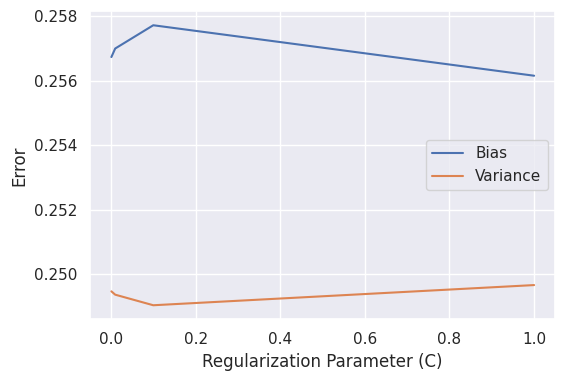

In [ ]:
# Define a function to compute the bias and variance components of the model's error
def bias_variance_decomposition(y_true, y_pred):
    """
    Computes the bias and variance components of the model's error.
    """
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    bias = np.mean((y_true_mean - y_pred)**2)
    variance = np.mean((y_pred - y_pred_mean)**2)
    return bias, variance

# Define a range of regularization parameters to try
lambda_values = [0.001, .01, 0.1, 1]

# Initialize arrays to store bias and variance values for each parameter value
bias_values = []
variance_values = []

# Loop over the parameter values and fit a logistic regression model for each value
for C in lambda_values:
    # Train logistic regression model
    lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=False,stochastic_gd= True, regularization=False,lasso=True, ridge_lambda=C)
    lr.fit(X_train, y_train)

    # Evaluate model on test set and compute bias and variance
    y_pred = lr.predict(X_test)
    bias, variance = bias_variance_decomposition(y_test, y_pred)

    # Append bias and variance values to arrays
    bias_values.append(bias)
    variance_values.append(variance)

# Plot the bias and variance values as a function of the regularization parameter
plt.plot(lambda_values, bias_values, label='Bias')
plt.plot(lambda_values, variance_values, label='Variance')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=False,stochastic_gd= True, regularization=False,lasso=True, ridge_lambda=0.1)

**Tackle bias variance tradeoff is by using REGULARIZATION**

Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 10%|▉         | 490/5000 [00:05<00:49, 90.47it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  3%|▎         | 135/5000 [00:01<00:55, 87.96it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  3%|▎         | 129/5000 [00:02<01:33, 51.84it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  1%|▏         | 69/5000 [00:00<00:53, 91.97it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  1%|          | 37/5000 [00:00<00:56, 87.38it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  8%|▊         | 410/5000 [00:04<00:51, 88.79it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  3%|▎         | 172/5000 [00:01<00:53, 89.95it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  3%|▎         | 128/5000 [00:01<00:55, 88.34it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 18%|█▊        | 893/5000 [00:10<00:50, 81.84it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  5%|▍         | 239/5000 [00:03<01:12, 65.98it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 17%|█▋        | 854/5000 [00:09<00:47, 88.14it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 12%|█▏        | 602/5000 [00:08<01:00, 73.16it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 31%|███       | 1541/5000 [00:18<00:42, 81.18it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 33%|███▎      | 1670/5000 [00:19<00:39, 85.03it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  3%|▎         | 172/5000 [00:02<01:07, 71.94it/s]


Model stopped running


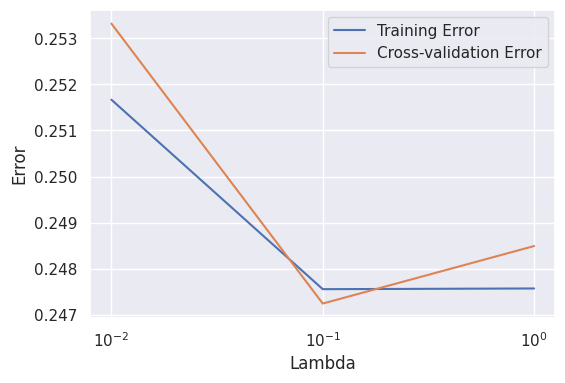

In [ ]:
from sklearn.model_selection import KFold

X_train = pd.DataFrame(data=X_train)

# Define the range of lambda values to test
lambdas = np.logspace(-2, 0, num=3)

# Initialize lists to store the cost function values for each lambda value
train_errors = []
cv_errors = []

# Loop over each lambda value
for lambda_val in lambdas:
    # Initialize lists to store the cost function values for each fold
    train_fold_errors = []
    cv_fold_errors = []
    
    
    # Perform K-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, cv_index in kf.split(X_train):
        # Split the data into training and cross-validation sets
        X_train_fold, X_cv_fold = X_train.iloc[train_index], X_train.iloc[cv_index]
        y_train_fold, y_cv_fold = y_train[train_index], y_train[cv_index]
        
        # Train a Ridge regression model with the current lambda value
        lr = LogisticRegression(X,y, learningRate = 0.0001, tolerance = 0.00005, maxIteration = 5000, gd=False,stochastic_gd= True, regularization=False,lasso=True, ridge_lambda=lambda_val)
        lr.fit(X_train_fold, y_train_fold)
        
        # Compute the cost function J(theta) for the training set
        train_predictions = lr.predict(X_train_fold)
        train_error = np.mean((train_predictions - y_train_fold)**2)
        train_fold_errors.append(train_error)
        
        # Compute the cost function J(theta) for the cross-validation set
        cv_predictions = lr.predict(X_cv_fold)
        cv_error = np.mean((cv_predictions - y_cv_fold)**2)
        cv_fold_errors.append(cv_error)
    
    # Compute the average cost function J(theta) over all the folds
    train_error_avg = np.mean(train_fold_errors)
    cv_error_avg = np.mean(cv_fold_errors)
    
    # Append the average cost function values to the list
    train_errors.append(train_error_avg)
    cv_errors.append(cv_error_avg)

# Plot the average cost function J(theta) against the lambda values
plt.plot(lambdas, train_errors, label='Training Error')
plt.plot(lambdas, cv_errors, label='Cross-validation Error')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.xscale('log')
plt.legend()
plt.show()

**CROSS VALIDATION**

Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  9%|▉         | 463/5000 [00:12<02:06, 35.99it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  6%|▌         | 299/5000 [00:05<01:28, 53.22it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  2%|▏         | 95/5000 [00:02<01:44, 47.02it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 13%|█▎        | 631/5000 [00:17<02:00, 36.38it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 17%|█▋        | 852/5000 [00:22<01:48, 38.37it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 11%|█         | 536/5000 [00:12<01:41, 44.18it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 53%|█████▎    | 2661/5000 [01:06<00:58, 39.86it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  9%|▉         | 473/5000 [00:09<01:30, 50.03it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  4%|▍         | 219/5000 [00:08<02:55, 27.22it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 18%|█▊        | 875/5000 [00:21<01:39, 41.55it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


  1%|          | 61/5000 [00:01<01:36, 51.30it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 26%|██▋       | 1317/5000 [00:33<01:34, 39.17it/s]


Model stopped running
Solving using Gradient Descent
Solved using stochastic gradient descent with regularization- LASSO REGRESSION


 21%|██        | 1038/5000 [00:23<01:31, 43.45it/s]

Model stopped running


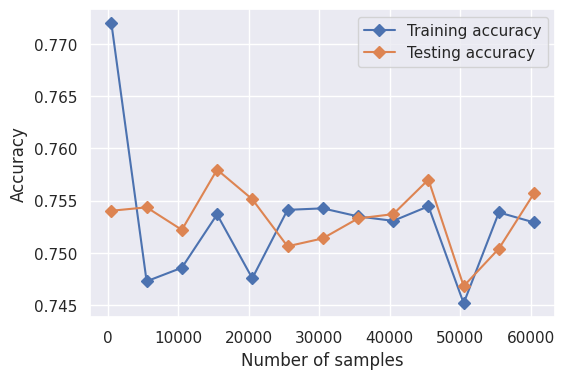

In [ ]:
# CODE for BIAS- VARIANCE TRADEOFF EXPLANATION

# Set up empty lists to store results
train_acc = []
test_acc = []
num_samples = []

# Define range of sample sizes to test
sample_sizes = range(500, len(X), 5000)

for size in sample_sizes:
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size)
    
    # Train
    lr.fit(X_train,y_train)
    
    # Calculate accuracy on training and testing sets
    train_pred = lr.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_pred))
    
    test_pred = lr.predict(X_test)
    test_acc.append(accuracy_score(y_test, test_pred))
    
    # Store number of samples used in training set
    num_samples.append(size)

# Plot accuracy versus number of samples
plt.plot(num_samples, train_acc, label='Training accuracy', marker='D')
plt.plot(num_samples, test_acc, label='Testing accuracy', marker='D')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.legend()

# **DECISION TREE**

In [ ]:
# create X and y matrices
X = df4.drop('class', axis=1).values # drop the 'class' column and convert to numpy array
y = np.where(df4['class'] == 'p', 1, 0) # create a binary target variable (1 for poisonous, 0 for edible)

print(X.shape)
print(y.shape)

(61069, 82)
(61069,)


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=50, n_features= None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)
        
    def _selected_features(self, X):
        n_samples = X.shape[1]
        idxs = np.random.choice(n_samples, self.n_features, replace=False)
        return X[:,idxs]

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, n_feats, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def predict_proba(self, X):
        # Get the predicted probabilities from the model
        y_pred = self.predict(X)
    
        # Compute the class probabilities
        proba = np.zeros((X.shape[0], 2))
        proba[:, 0] = 1 - y_pred
        proba[:, 1] = y_pred
    
        return proba
    
    def evaluate(self, y, y_hat):
        y = (y==1)
        y_hat = (y_hat == 1)        
        correct_predictions = (y == y_hat).sum()
        total_predictions = len(y)
        accuracy = correct_predictions / total_predictions
        recall = (y & y_hat).sum()/y.sum()
        precision = (y & y_hat).sum()/y_hat.sum()
        f_score = 2*(precision*recall)/(precision+recall)
        return accuracy, f_score, recall, precision

    
    def scores(self,X,y):
        y_train_hat = self.predict(X_train)
        accuracy, f_score, recall, precision = self.evaluate(y_train, y_train_hat)
        print('Training F1 score {}'.format(f_score))
        print('Training recall score {}'.format(recall))
        print('Training precision score {}'.format(precision))
        print('Training accuracy score {}'.format(accuracy))
        print('-----------------------------------------------')
        y_test_hat= self.predict(X_test)
        accuracy,f_score, recall, precision = self.evaluate(y_test, y_test_hat)
        print('Testing F1 score {}'.format(f_score))
        print('Testing recall score {}'.format(recall))
        print('Testing precision score {}'.format(precision))
        print('Testing accuracy score {}'.format(accuracy))

        y_pred_proba = self.predict_proba(X_test)[:, 1] # Call predict_proba method on trained model object
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [ ]:
dt = DecisionTree(max_depth=15)

In [ ]:
dt.fit(X_train, y_train)

In [ ]:
y_pred = dt.predict(X_test)

Training F1 score 0.989961617950989
Training recall score 0.9894503873109554
Training precision score 0.9904733771508751
Training accuracy score 0.9888650086992119
-----------------------------------------------
Testing F1 score 0.9864914741271131
Testing recall score 0.9858365299498377
Testing precision score 0.9871472891121288
Testing accuracy score 0.9850171933846406


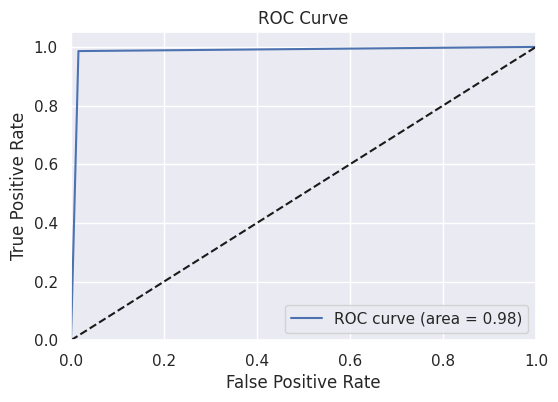

In [ ]:
dt.scores(X_train,y_train)

In [ ]:
accuracy_score(y_test, y_pred)

0.9850171933846406

In [ ]:
roc_auc_score(y_test, y_pred)

0.9849160574694

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5436
           1       0.99      0.99      0.99      6778

    accuracy                           0.99     12214
   macro avg       0.98      0.98      0.98     12214
weighted avg       0.99      0.99      0.99     12214



In [ ]:
confusion_matrix(y_test, y_pred, )

array([[5349,   87],
       [  96, 6682]])

**CROSS VALIDATION**

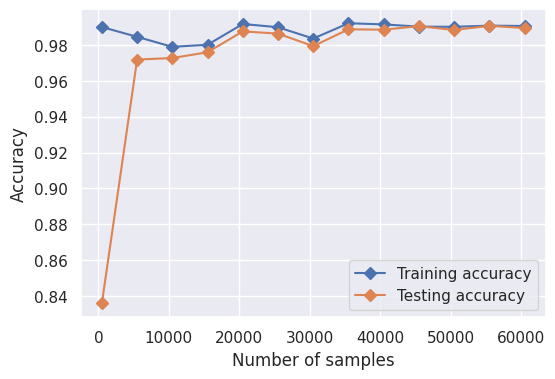

In [ ]:


# Set up empty lists to store results
train_acc = []
test_acc = []
num_samples = []

# Define range of sample sizes to test
sample_sizes = range(500, len(X), 5000)

for size in sample_sizes:
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size)
    
    # Train
    dt.fit(X_train, y_train)
    
    # Calculate accuracy on training and testing sets
    train_pred = dt.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_pred))
    
    test_pred = dt.predict(X_test)
    test_acc.append(accuracy_score(y_test, test_pred))
    
    # Store number of samples used in training set
    num_samples.append(size)

# Plot accuracy versus number of samples
plt.plot(num_samples, train_acc, label='Training accuracy', marker='D')
plt.plot(num_samples, test_acc, label='Testing accuracy', marker='D')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.legend()

# **RANDOM FOREST**

In [ ]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth= 5, min_samples_split=2, sample_size=1000):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.trees = []
        self.sample_size = sample_size

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, self.sample_size, replace=True)
        return X[idxs, ], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions
    
    def predict_proba(self, X):
        # Get the predicted probabilities from the model
        y_pred = self.predict(X)
    
        # Compute the class probabilities
        proba = np.zeros((X.shape[0], 2))
        proba[:, 0] = 1 - y_pred
        proba[:, 1] = y_pred
    
        return proba
    
    def evaluate(self, y, y_hat):
        y = (y==1)
        y_hat = (y_hat == 1)        
        correct_predictions = (y == y_hat).sum()
        total_predictions = len(y)
        accuracy = correct_predictions / total_predictions
        recall = (y & y_hat).sum()/y.sum()
        precision = (y & y_hat).sum()/y_hat.sum()
        f_score = 2*(precision*recall)/(precision+recall)
        return accuracy, f_score, recall, precision

    
    def scores(self,X,y):
        y_train_hat = self.predict(X_train)
        accuracy, f_score, recall, precision = self.evaluate(y_train, y_train_hat)
        print('Training F1 score {}'.format(f_score))
        print('Training recall score {}'.format(recall))
        print('Training precision score {}'.format(precision))
        print('Training accuracy score {}'.format(accuracy))
        print('-----------------------------------------------')
        y_test_hat= self.predict(X_test)
        accuracy,f_score, recall, precision = self.evaluate(y_test, y_test_hat)
        print('Testing F1 score {}'.format(f_score))
        print('Testing recall score {}'.format(recall))
        print('Testing precision score {}'.format(precision))
        print('Testing accuracy score {}'.format(accuracy))

        y_pred_proba = self.predict_proba(X_test)[:, 1] # Call predict_proba method on trained model object
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
rf = RandomForest(sample_size=5000)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)
#accuracy_score(y_test, y_pred)

Training F1 score 0.6955287437899218
Training recall score 0.5783758262511803
Training precision score 0.8721965112139551
Training accuracy score 0.719001768520338
-----------------------------------------------
Testing F1 score 0.6965732973126689
Testing recall score 0.578257790368272
Testing precision score 0.8757597425813372
Testing accuracy score 0.7204610951008645


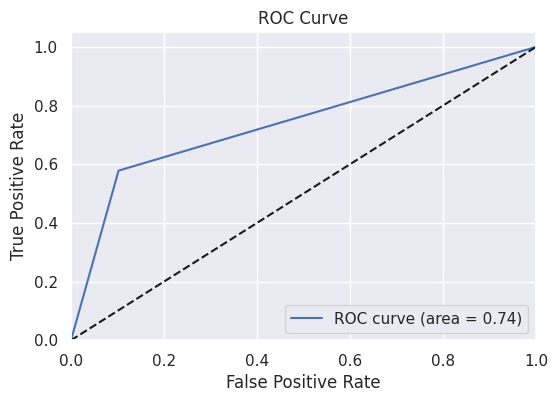

In [ ]:
rf.scores(X_train,y_train)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.86      0.74      6796
           1       0.85      0.63      0.72      8472

    accuracy                           0.73     15268
   macro avg       0.75      0.75      0.73     15268
weighted avg       0.76      0.73      0.73     15268



# **NEURAL NETWORKS**

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.api._v2.keras import activations
from tensorflow import metrics

In [ ]:
model1 = Sequential()
model1.add(Dense(8, activation = 'relu', input_dim= 82))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow import metrics
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics= 'accuracy')

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 664       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(X_train, y_train, epochs=10)

Epoch 1/10
1527/1527 [==============================] - 3s 1ms/step - loss: 0.5374 - accuracy: 0.7291
Epoch 2/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.3422 - accuracy: 0.8679
Epoch 3/10
1527/1527 [==============================] - 2s 2ms/step - loss: 0.2496 - accuracy: 0.9128
Epoch 4/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.1958 - accuracy: 0.9345
Epoch 5/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.1555 - accuracy: 0.9483
Epoch 6/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.1271 - accuracy: 0.9573
Epoch 7/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.1075 - accuracy: 0.9637
Epoch 8/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.0925 - accuracy: 0.9701
Epoch 9/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.0816 - accuracy: 0.9741
Epoch 10/10
1527/1527 [==============================] - 2s 1ms/step - loss: 0.073

In [ ]:
y_hat = model1.predict(X_test)

382/382 [==============================] - 0s 918us/step


In [ ]:
y_hat

array([[5.4652359e-02],
       [9.9999303e-01],
       [8.4986252e-01],
       ...,
       [9.9996430e-01],
       [4.8760148e-03],
       [1.6438496e-06]], dtype=float32)

In [ ]:
y_hat = [0 if x < 0.5 else 1 for x in y_hat]

In [ ]:
roc_auc_score(y_test, y_hat)

0.9790192255123108

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5436
           1       0.98      0.98      0.98      6778

    accuracy                           0.98     12214
   macro avg       0.98      0.98      0.98     12214
weighted avg       0.98      0.98      0.98     12214

